# Coffea from ground up

The goal of this notebook is to understand coffea better and learn how you can make analysis from scratch.  

In [1]:
# First we import packages
# but let's understand actually what these are doing

# Scientific python packages
# these are standard packages widely used in scientific computing, not limited to HEP
# there are more, like scipy, pandas, and sympy, etc.
import numpy as np # implement high performance arrays optimized and operations (array operations)
import matplotlib.pyplot as plt # make plots

# scikit-hep packages
# these are packages developed specifically for HEP
# there are more, see https://scikit-hep.org
# also tutorial: https://hsf-training.github.io/hsf-training-scikit-hep-webpage/index.html
import uproot # read/write root files
import awkward as ak # similar to np.arrays, but allow jagged arrays
import hist # make histogram
import mplhep as hep # make matplotlib plots in LHC's publication style

# coffea framework
# coffea is built on top of several scikit-hep, mainly uproot and awkward
# documentation https://coffeateam.github.io/coffea
import coffea

## Q1: I just want to make histogram of something in NanoAOD. How can I do that?

There are two ways: 

(1) uproot + awkward

(2) coffea

Coffea provides a nice "schema", which is a template of objects included in NanoAOD. Moreover, coffea will organize acessing properties of objects in an inutitive hierarchical way. So it is recommended to go with second option and we will only go over coffea option.

In [2]:
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema

In [3]:
# pick filename
#fname = "https://raw.githubusercontent.com/CoffeaTeam/coffea/master/tests/samples/nano_dy.root"
fname = "/eos/cms/store/group/phys_jetmet/JMENanoRun3/v2p1/JetMET/JMENanoRun3_v2p1_Run2022D-PromptReco-v2/220915_173253/0000/tree_393.root"
fname = "/eos/cms/store/group/phys_jetmet/JMENanoRun3/v2p1/QCD_Pt-15to7000_TuneCP5_Flat_13p6TeV_pythia8/JMENanoRun3_v2p1_MC22_122/220915_171347/0000/tree_206.root"

# coffea implements NanoEventsFactory which produces events from root
events = NanoEventsFactory.from_root( # apart from root, coffea supports several other file types, e.g. parquet
            fname,
            schemaclass=NanoAODSchema.v6, # schema to use
            metadata={"dataset": "JetMET"}, # you can put metadata like this, e.g. dataset name
            ).events() # finally, call factory to give us events

In [4]:
# let's see what are in schema
# here, mixins is a map from object's name stored in NanoAOD to pre-defined object types in coffea
# these object types make interacting with them more intuitive
# for example, Jet (AK4CHS; this file is run2) is a Jet, of course. But, GenJet, Fatjet,... are also Jets.
NanoAODSchema.mixins;

In [5]:
# we can inspect events
events;

# here, you can see type = 40 * events
# 40 is a number of events
# if you want to print, this is repr(events)

In [6]:
# you can see the contents of events by calling fields
sorted(events.fields);

In [7]:
# similarly, we can inspect Jet
events.Jet;

# we can see type=40 * var * jet
# 40 is again, number of events
# And the last "jet" is saying this is jet collection
# The interesting part is var, which is "variable"
# In each event, the number of jets are not the same
# This arrays is called "jagged" array
# Since np.array can only represent regular or square array, awkward array is developed for this reason
# Awkward syntaxes are very similar to numpy
# You can even use numpy functions on awkward array

In [8]:
# Now, what types of Jet is this? 
# You can access __doc__ to get more information
# of course, this relies on that NanoAOD you have is well-documented...
events.Jet.__doc__;

In [9]:
# you can also, access Jet with dictionary-like syntax
events["Jet"];

In [10]:
# Similarly, you can see the contents of events by calling fields
sorted(events.Jet.fields);

In [11]:
# Similarly, we can get Jet pt by
events.Jet.pt;

In [12]:
# Or
events["Jet"].pt;

In [13]:
# Or
events.Jet["pt"];

In [14]:
# Or
events["Jet", "pt"];

In [15]:
# Question: in NanoAOD, this is saved as Jet_pt
# How might you access this with Jet_pt string? 

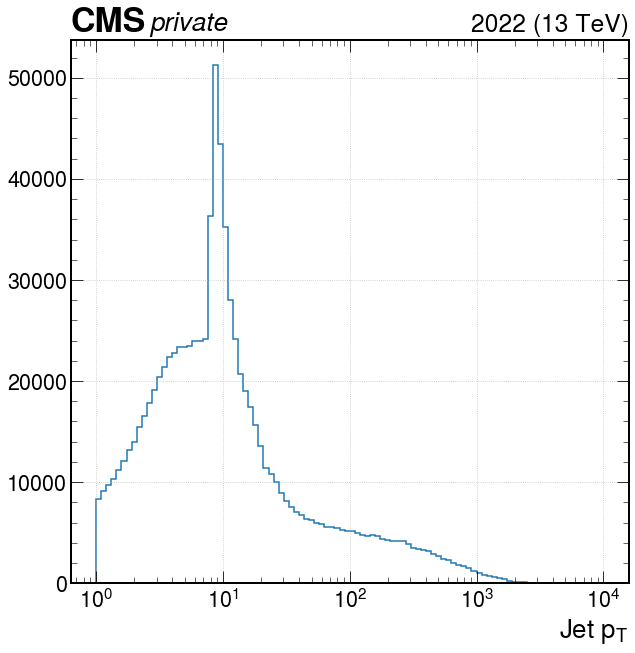

In [16]:
# now, let's make a histogram

# create new histogram
h_AK4pt = hist.new.Regular(100, 1, 10000, name="jet_pt", label=r"Jet $p_T$", 
                           transform=hist.axis.transform.log).Double()

# fill histogram
h_AK4pt.fill(jet_pt = ak.flatten(events.Jet.pt))

hep.style.use("CMS") # use CMS styles

fig, ax = plt.subplots() # get axis from plt

h_AK4pt.plot(ax=ax, yerr=False) # plot

ax.set_xscale("log") # set x scale in plot
ax.set_ylabel("")
ax.grid()

hep.cms.label(label="private", loc=0, data=True, year="2022") # decorate plot
plt.show()

In [17]:
# Ok let's discuss hist a bit
# you can access bin counts
h_AK4pt.counts();

In [18]:
# you can access bin values
h_AK4pt.values();

# what is the difference between bin counts and bin values?
# they are different when histograms are weighted, e.g. with eventweight in MC
# counts = unweighted number of data in each bin
# values = weighted number of data in each bin

In [19]:
# you can get bin's information by first accessing axes
h_AK4pt.axes

(Regular(100, 1, 10000, transform=log, name='jet_pt', label='Jet $p_T$'))

In [20]:
# can access by index
h_AK4pt.axes[0] 

Regular(100, 1, 10000, transform=log, name='jet_pt', label='Jet $p_T$')

In [21]:
# or by access' name
h_AK4pt.axes["jet_pt"]

Regular(100, 1, 10000, transform=log, name='jet_pt', label='Jet $p_T$')

In [22]:
# then, you can get, for example, bin edges
h_AK4pt.axes["jet_pt"].edges;

In [23]:
# or bin centers
h_AK4pt.axes["jet_pt"].centers;

In [24]:
# slicing by bin indices
hep.style.use("CMS") # use CMS styles

fig, ax = plt.subplots() # get axis from plt

h_AK4pt[30:50].plot(ax=ax, yerr=False) # plot

ax.set_xscale("log") # set x scale in plot
ax.set_ylabel("")
ax.grid()

hep.cms.label(label="private", loc=0, data=True, year="2022") # decorate plot
plt.show()

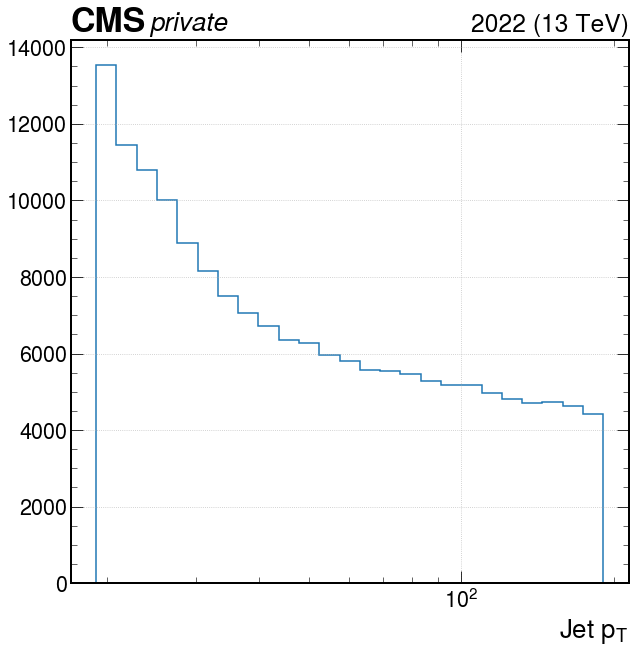

In [25]:
# slicing by values, using imaginary j
hep.style.use("CMS") # use CMS styles

fig, ax = plt.subplots() # get axis from plt

h_AK4pt[20j:200j].plot(ax=ax, yerr=False) # plot

ax.set_xscale("log") # set x scale in plot
ax.set_ylabel("")
ax.grid()

hep.cms.label(label="private", loc=0, data=True, year="2022") # decorate plot
plt.show()

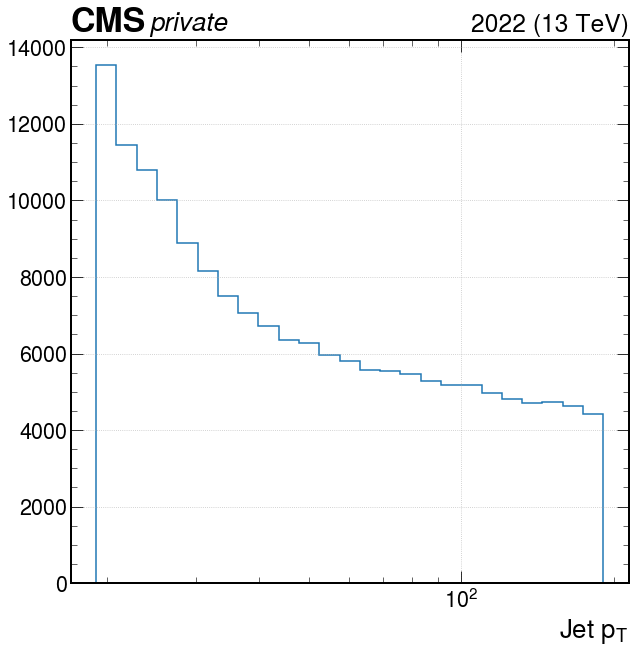

In [26]:
# slicing with slice
hep.style.use("CMS") # use CMS styles

fig, ax = plt.subplots() # get axis from plt

h_AK4pt[slice(20j, 200j, None)].plot(ax=ax, yerr=False) # plot

ax.set_xscale("log") # set x scale in plot
ax.set_ylabel("")
ax.grid()

hep.cms.label(label="private", loc=0, data=True, year="2022") # decorate plot
plt.show()

In [27]:
# you can also integrate the whole histogram like this
h_AK4pt[sum]

969308.0

In [28]:
# you can integrate histogram in specific range
# slice object last argument is reduction operation
# None = no reduction
# we can use sum here
# and we're integrating histogram in range (20, 200)!
h_AK4pt[slice(20j, 200j, sum)]

168998.0

In [29]:
# Question: how can we integrate two disjoint ranges?

In [30]:
# you can profile (computing mean) along axis
h_AK4pt.profile("jet_pt")

Hist(storage=Mean()) # Sum: Mean(count=903163, value=48.0456, variance=21949.2)

In [31]:
# you can project to axis/axes (integrating all other axes)
h_AK4pt.project() 
# h_AK4pt.project("jet_pt")

Hist(storage=Double()) # Sum: 969308.0

### Exercise 1: Plot Jet eta
This is a simple exercise for you to get your hands dirty! Just repeat the steps and plot Jet eta. What is special characteristic you see?

Hints: plot vertical lines at [-5, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5]

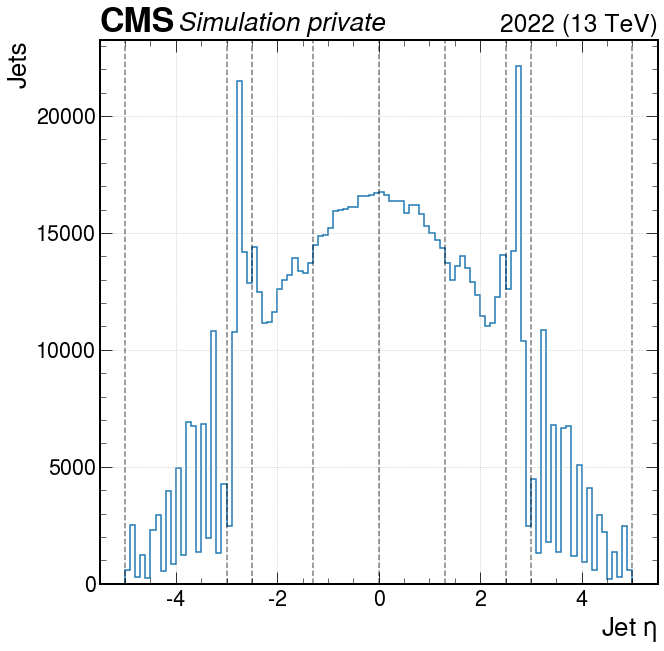

In [32]:
h_jet_eta = hist.new.Regular(100, -5, 5, name="jet_eta", label="Jet $\eta$").Int64()
h_jet_eta.fill(jet_eta=ak.flatten(events.Jet.eta))

hep.style.use("CMS") # use CMS styles

fig, ax = plt.subplots() # get axis from plt

h_jet_eta.plot(ax=ax, yerr=False) # plot

ax.set_ylabel("Jets")
ax.grid()

for x in [-5, -3, -2.5, -1.3, 0, 1.3, 2.5, 3, 5]:
    ax.axvline(x=x, linestyle="dashed", alpha=0.5, color="k")

hep.cms.label(label="private", loc=0, data=False, year="2022") # decorate plot
plt.show()

### Exercise 2: Plot AK4Jet area vs AK8Jet area on the same histogram
Overlay AK4Jet and AK8Jet area on the same plot and draw vertical lines corresponding to $\pi R^2$ where $R$ is cone-size used in anti-kt algorithm.

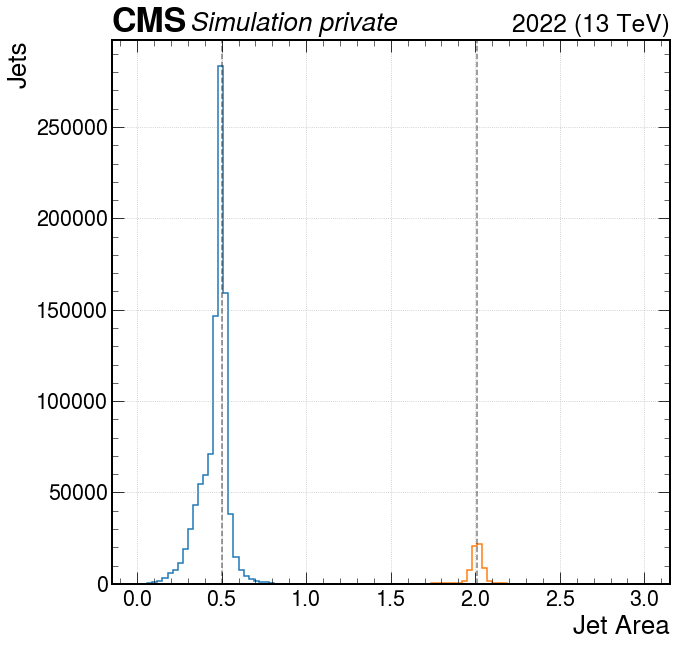

In [33]:
h_ak4_area = hist.new.Regular(100, 0, 3, name="jet_area", label="Jet Area").Int64()
h_ak4_area.fill(jet_area=ak.flatten(events.Jet.area))

h_ak8_area = hist.new.Regular(100, 0, 3, name="jet_area", label="Jet Area").Int64()
h_ak8_area.fill(jet_area=ak.flatten(events.FatJet.area))

hep.style.use("CMS") # use CMS styles

fig, ax = plt.subplots() # get axis from plt

h_ak4_area.plot(ax=ax, yerr=False, label="AK4") # plot
h_ak8_area.plot(ax=ax, yerr=False, label="AK8")

ax.set_ylabel("Jets")
ax.grid()

ax.axvline(x=np.pi*0.4*0.4, linestyle="--", color="k" ,alpha=0.5)
ax.axvline(x=np.pi*0.8*0.8, linestyle="--", color="k" ,alpha=0.5)

hep.cms.label(label="private", loc=0, data=False, year="2022") # decorate plot
plt.show()

### Exercise 4: Plot Jet Energy Fractions
This is quite similar to Exercise 2. Plot (charged, neutral) x (ECAL, HCAL) + Muon energy fraction in jet. This is to help you get to read documentation! What do jets consist of mostly?

NanoAOD datatier: https://twiki.cern.ch/twiki/bin/view/CMSPublic/WorkBookNanoAOD

Now, we will use array operations implemented in numpy. awkward has similar syntaxes to numpy. If awkward array function does not exist, you can use numpy functions on awkward arrays!

In [34]:
energy_fraction_names = ["chEmEF", "chHEF", "neEmEF", "neHEF", "muEF"]
energy_fraction_labels = ["Charged Electromagnetic", "Charged Hadron", "Neutral Electromagnetic", "Neutral Hadron", "Muon"]

h_ef = dict()
for energy_fraction_name in energy_fraction_names:
    h_ef[energy_fraction_name] = hist.new.Regular(20, 0, 1, name="ef", label="Energy Fraction").Int64()
    h_ef[energy_fraction_name].fill(ak.flatten(events.Jet[energy_fraction_name]))

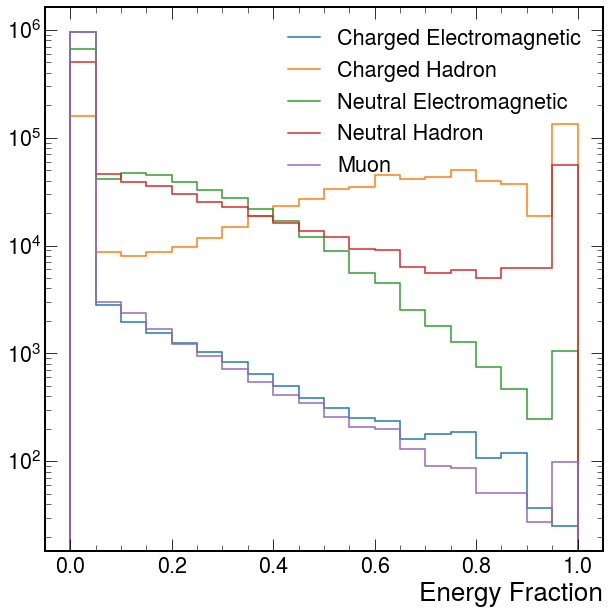

In [35]:
fig, ax = plt.subplots()
for energy_fraction_name, energy_fraction_label in zip(energy_fraction_names, energy_fraction_labels):
    h_ef[energy_fraction_name].plot(ax=ax, yerr=False, label=energy_fraction_label)

ax.set_yscale("log")
ax.legend()
plt.show()

In [36]:
# let's look at Jet pt again
events.Jet.pt

<Array [[47.7, 32.6, 25.5, ... 0.573, 0.402]] type='58000 * var * float32[parame...'>

In [37]:
events.Jet.pt[0]

<Array [47.7, 32.6, 25.5, ... 2.71, 2.58, 1.52] type='28 * float32[parameters={"...'>

In [38]:
events.Jet.pt[1]

<Array [313, 216, 29.2, ... 8.29, 6.43, 2.91] type='10 * float32[parameters={"__...'>

In [39]:
# So events.Jet.pt is 2-D array of Jet: number of events x number of jets

# let's try this
events.Jet.pt[:, 0];

ValueError: in ListOffsetArray64 attempting to get 0, index out of range

(https://github.com/scikit-hep/awkward-1.0/blob/1.10.1/src/cpu-kernels/awkward_NumpyArray_getitem_next_at.cpp#L21)

In [40]:
# let's select only events with at least 2 jets
at_least_two_jets_events = events[ak.num(events.Jet) >= 2]
at_least_two_jets_events

<NanoEventsArray [<event 1:155:154002>, ... ] type='57993 * event'>

In [41]:
leading_jet_pt = at_least_two_jets_events.Jet.pt[:, 0]
subleading_jet_pt = at_least_two_jets_events.Jet.pt[:, 1]

In [42]:
leading_jet_pt

<Array [47.7, 313, 91.8, ... 1.67e+03, 458] type='57993 * float32[parameters={"_...'>

In [43]:
subleading_jet_pt

<Array [32.6, 216, 73.8, ... 1.48e+03, 356] type='57993 * float32[parameters={"_...'>

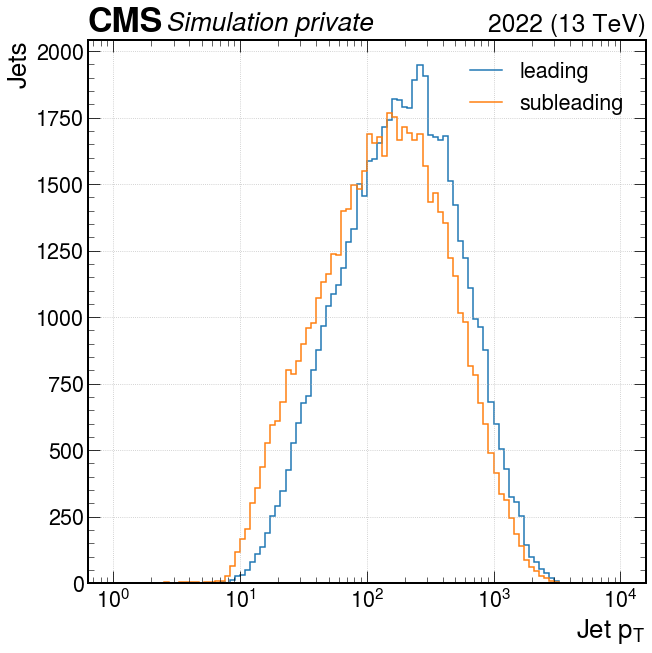

In [44]:
h_leading_jet_pt = hist.new.Regular(100, 1, 10000, name="jet_pt", label=r"Jet $p_T$", 
                           transform=hist.axis.transform.log).Double()
h_leading_jet_pt.fill(jet_pt=leading_jet_pt)

h_subleading_jet_pt = hist.new.Regular(100, 1, 10000, name="jet_pt", label=r"Jet $p_T$", 
                           transform=hist.axis.transform.log).Double()
h_subleading_jet_pt.fill(jet_pt=subleading_jet_pt)

hep.style.use("CMS") # use CMS styles

fig, ax = plt.subplots() # get axis from plt

h_leading_jet_pt.plot(ax=ax, yerr=False, label="leading") # plot
h_subleading_jet_pt.plot(ax=ax, yerr=False, label="subleading")

ax.set_ylabel("Jets")
ax.set_xscale("log")
ax.grid()

ax.legend()

hep.cms.label(label="private", loc=0, data=False, year="2022") # decorate plot
plt.show()

In [45]:
dphi = at_least_two_jets_events.Jet[:, 0].phi - at_least_two_jets_events.Jet[:, 1].phi
opposite_cut = np.abs(dphi) > 2.7

In [46]:
dijet_events = at_least_two_jets_events[opposite_cut]
dijet_events 

<NanoEventsArray [<event 1:155:154002>, ... ] type='49998 * event'>

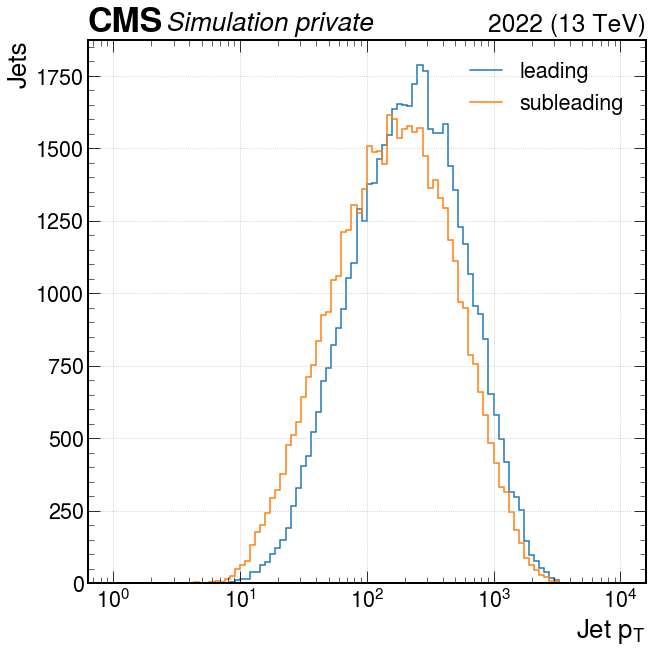

In [47]:
h_leading_jet_pt = hist.new.Regular(100, 1, 10000, name="jet_pt", label=r"Jet $p_T$", 
                           transform=hist.axis.transform.log).Double()
h_leading_jet_pt.fill(jet_pt=dijet_events.Jet.pt[:, 0])

h_subleading_jet_pt = hist.new.Regular(100, 1, 10000, name="jet_pt", label=r"Jet $p_T$", 
                           transform=hist.axis.transform.log).Double()
h_subleading_jet_pt.fill(jet_pt=dijet_events.Jet.pt[:, 1])

hep.style.use("CMS") # use CMS styles

fig, ax = plt.subplots() # get axis from plt

h_leading_jet_pt.plot(ax=ax, yerr=False, label="leading") # plot
h_subleading_jet_pt.plot(ax=ax, yerr=False, label="subleading")

ax.set_ylabel("Jets")
ax.set_xscale("log")
ax.grid()

ax.legend()

hep.cms.label(label="private", loc=0, data=False, year="2022") # decorate plot
plt.show()

### Exercise 5: Plot Jet flavours
Now, you will apply some cuts to select jets with different flavours. Jet flavours from MC simulation is stored in "Jet_partonFlavour":

- 1: d
- 2: u
- 3: s
- 4: c
- 5: b
- 21: g
- 0: unmatched

and negatives are corresponding anti-quarks

If you're done early, in reality, we cannot tell uds quarks apart for now. So make another histogram with g, uds, c, b, g, and unmatched. That is, combine uds results (there are two approaches!)

Plot these quantities: pt and some b-tagger: (btagDeepB, btagDeepFlavB, and particleNetAK4_B)

In [48]:
flavour_map = {1: "d", 2: "u", 3: "s", 4: "c", 5: "b", 21: "g"}
h_flavour = dict()

for flavour_idx, flavour in flavour_map.items():
    # initiate
    h_flavour[flavour_idx] = hist.new.Regular(100, 1, 10000, name="jet_pt", label=r"Jet $p_T$", 
                           transform=hist.axis.transform.log).Int64()
    
    # fill
    h_flavour[flavour_idx].fill(jet_pt = ak.flatten(events.Jet[events.Jet.partonFlavour == flavour_idx].pt))

fig, ax = plt.subplots()
for flavour_idx, flavour in flavour_map.items():
    h_flavour[flavour_idx].plot(ax=ax, yerr=False, label=flavour)

ax.set_yscale("log")
ax.set_xscale("log")
ax.legend()
plt.show()

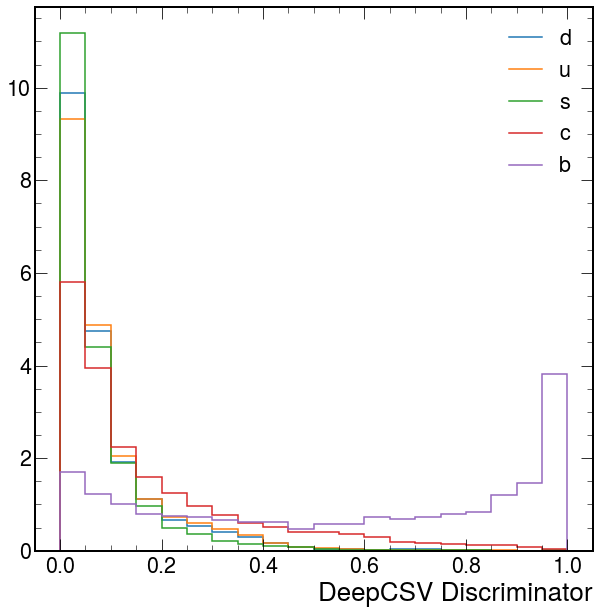

In [50]:
b_tagger_namaes = ["btagDeepB", "btagDeepFlavB", "particleNetAK4_B"]
b_tagger_labels = ["DeepCSV", "DeepJet", "ParticleNet"]
for b_tagger_name, b_tagger_label in zip(b_tagger_namaes, b_tagger_labels):
    for flavour_idx, flavour in flavour_map.items():
        # initiate
        h_flavour[flavour_idx] = hist.new.Regular(20, 0, 1, name="disc", 
                                                  label="{} Discriminator".format(b_tagger_label)).Int64()

        # fill
        flavour_jets = events.Jet[events.Jet.partonFlavour == flavour_idx]
        h_flavour[flavour_idx].fill(disc=ak.flatten(flavour_jets[b_tagger_name]))

    fig, ax = plt.subplots()
    for flavour_idx, flavour in flavour_map.items():
        if flavour_idx == 0 or flavour_idx == 21:
            continue
        h_flavour[flavour_idx].plot(ax=ax, yerr=False, label=flavour, density=True)

    ax.legend()
    plt.show()

In [51]:
# Ok, let's look at something else, apart from jets

muon_fname = "/eos/cms/store/group/phys_jetmet/JMENanoRun3/v2p1/Muon/JMENanoRun3_v2p1_Run2022E-PromptReco-v1/221007_173948/0000/tree_785.root"
# coffea implements NanoEventsFactory which produces events from root
muon_events = NanoEventsFactory.from_root( # apart from root, coffea supports several other file types, e.g. parquet
                muon_fname,
                schemaclass=NanoAODSchema.v6, # schema to use
                metadata={"dataset": "Muon"}, # you can put metadata like this, e.g. dataset name
                ).events() # finally, call factory to give us events

In [52]:
# select events with two muon and divide into two categories
two_muon_events = muon_events[ak.num(muon_events.Muon)==2]
same_charge_muon_events = two_muon_events[two_muon_events.Muon[:, 0].charge == two_muon_events.Muon[:, 1].charge]
opposite_charge_muon_events = two_muon_events[two_muon_events.Muon[:, 0].charge != two_muon_events.Muon[:, 1].charge]

In [53]:
# compute 
same_charge_muon_events["MuonMass"] = (same_charge_muon_events.Muon[:, 0] + same_charge_muon_events.Muon[:, 1]).mass
opposite_charge_muon_events["MuonMass"] = (opposite_charge_muon_events.Muon[:, 0] + opposite_charge_muon_events.Muon[:, 1]).mass

In [54]:
# let's use one histogram this time, but we will add another axis for charge selection
h_dimuon = hist.new.StrCategory(["Same", "Opposite"], name="charge", label="charge selection")\
                   .Regular(100, 0, 200, name="mass", label="m_{\mu\mu}")\
                   .Weight()

In [55]:
# another way to define histogram
dimuon_mass_axis = hist.axis.Regular(100, 0, 200, name="mass", label="$m_{\mu\mu}$")
charge_axis = hist.axis.StrCategory(["Same", "Opposite"], name="charge", label="charge selection")

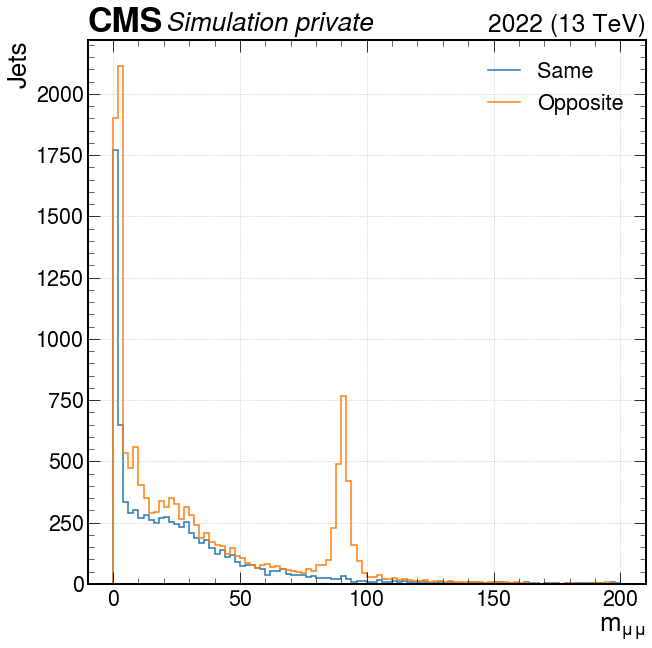

In [56]:
h_dimuon = hist.Hist(charge_axis, dimuon_mass_axis, storage=hist.storage.Weight())

h_dimuon.fill(charge="Same", mass=same_charge_muon_events["MuonMass"], weight=1)
h_dimuon.fill(charge="Opposite", mass=opposite_charge_muon_events["MuonMass"], weight=1)

hep.style.use("CMS") # use CMS styles

fig, ax = plt.subplots() # get axis from plt

h_dimuon.plot(ax=ax, yerr=False) 

ax.set_ylabel("Jets")
ax.grid()

ax.legend()

hep.cms.label(label="private", loc=0, data=False, year="2022") # decorate plot
plt.show()

In [57]:
## let's save histogram
from coffea import util as cutil
cutil.save({"dimuon": h_dimuon}, "output.coffea")

In [58]:
## now, load it back
cutil.load("output.coffea")

{'dimuon': Hist(
   StrCategory(['Same', 'Opposite'], name='charge', label='charge selection'),
   Regular(100, 0, 200, name='mass', label='$m_{\\mu\\mu}$'),
   storage=Weight()) # Sum: WeightedSum(value=23038, variance=23038) (WeightedSum(value=23317, variance=23317) with flow)}

In [59]:
# you can create a hist stack by turning one of string category into stack axis
h_dimuon_stack = h_dimuon.stack("charge")

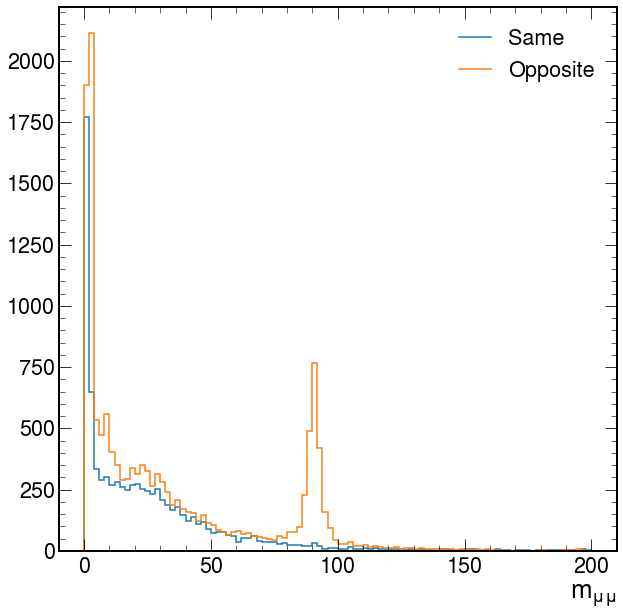

In [60]:
# you can also call plot on hist.stack
fig, ax = plt.subplots()
h_dimuon_stack.plot(ax=ax, yerr=False)

ax.legend()
plt.show()

In [61]:
# or you can use iterable, e.g. list or dict
h_AK4pt = hist.new.Regular(100, 1, 10000, name="jet_pt", label=r"Jet $p_T$", 
                           transform=hist.axis.transform.log).Double()
h_AK4pt.fill(jet_pt = ak.flatten(events.Jet.pt))
h_AK8pt = hist.new.Regular(100, 1, 10000, name="jet_pt", label=r"Jet $p_T$", 
                           transform=hist.axis.transform.log).Double()
h_AK8pt.fill(jet_pt = ak.flatten(events.FatJet.pt))

h_jet_pt = hist.Stack.from_dict({"AK4pt": h_AK4pt, "AK8pt": h_AK8pt})

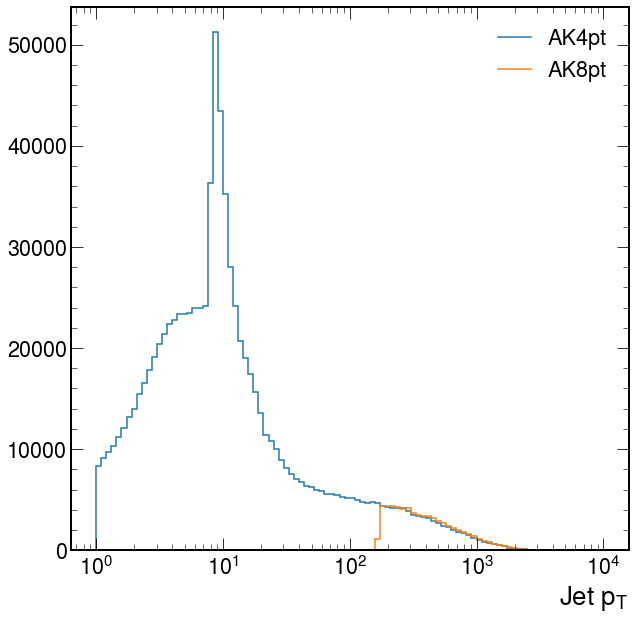

In [62]:
# you can also call plot on hist.stack
fig, ax = plt.subplots()
h_jet_pt.plot(ax=ax, yerr=False)

ax.set_xscale("log")
ax.legend()
plt.show()

In [63]:
## let's write histogram to root
outfile = uproot.recreate("output.root")
outfile["Jet_pt"] = h_AK4pt
outfile["FatJet_pt"] = h_AK8pt
outfile.close()

In [64]:
# let's open it
infile = uproot.open("output.root")

In [65]:
infile["Jet_pt"]

<TH1D (version 3) at 0x7fc224039040>

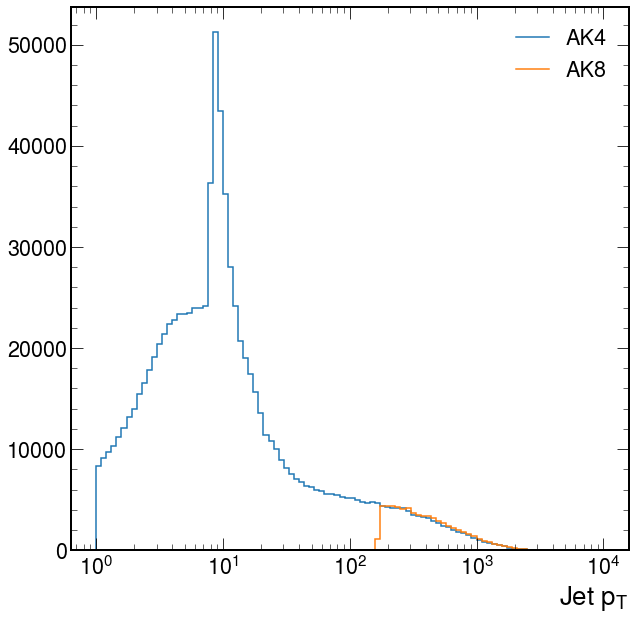

In [66]:
fig, ax = plt.subplots()
infile["Jet_pt"].to_hist().plot(ax=ax, yerr=False, label="AK4")
hist.Hist(infile["FatJet_pt"]).plot(ax=ax, yerr=False, label="AK8")

ax.set_xscale("log")
ax.legend()
plt.show()

### Exercise 6: Jet pt vs GenJet pt in 2D histogram
A first step for Jet Energy Correction (JEC)! 

In this exercise, we will first make a 2D histogram with x-axis as GenJet pt and y-axis as (Reco) Jet pt. Then, we will project to each axis and plot two 1D histograms in the same plot. 

To perform delta r matching
1. Use ak.cartesian to compute cartesian product between jets
2. Retrieve first jet and second jet in the cartesian product by .slot0 and .slot1
3. Match Reco Jet with Gen Jet within dR = 0.2. You can use Jet.delta_r(OtherJet) to compute dR

If you still cannot figure this out, you can look at https://github.com/patinkaew/online-offline-jec/blob/main/processor/selector.py#L782

## Q2: Columnar Analysis?

numpy array and awkward array perform array operation or Same Instruction Multiple Data (SIMD). In numpy terminology, this is called vectorization.

Even though coffea promote columnar analysis, which is simply just array operation, you can of course write code with event-loop with coffea which is much slower.

In [67]:
small_events = events[:10000]

In [68]:
%%time
h_jet_pt_loop = hist.new.Regular(100, 1, 10000, name="jet_pt", label=r"Jet $p_T$", 
                           transform=hist.axis.transform.log).Int64()
for event in small_events:
    for jet in event.Jet:
        if jet.eta < 1.3:
            h_jet_pt_loop.fill(jet_pt=jet.pt)

CPU times: user 23.1 s, sys: 577 ms, total: 23.7 s
Wall time: 23.4 s


In [69]:
%%time
h_jet_pt_no_loop = hist.new.Regular(100, 1, 10000, name="jet_pt", label=r"Jet $p_T$", 
                           transform=hist.axis.transform.log).Int64()

h_jet_pt_no_loop.fill(jet_pt=ak.flatten(small_events.Jet[small_events.Jet.eta < 1.3].pt));

CPU times: user 14.5 ms, sys: 66 µs, total: 14.6 ms
Wall time: 13.1 ms


Hist(Regular(100, 1, 10000, transform=log, name='jet_pt', label='Jet $p_T$'), storage=Int64()) # Sum: 111188.0 (119447.0 with flow)

In [70]:
fig, ax = plt.subplots()
h_jet_pt_loop.plot(ax=ax, yerr=False, label="Loop", alpha=0.5)
h_jet_pt_no_loop.plot(ax=ax, yerr=False, label="No loop", alpha=0.5)

ax.set_xscale("log")
ax.legend()
plt.show()